<a href="https://colab.research.google.com/github/caiocmello/Introduction-to-SA-Training-CAIS/blob/main/session_2/Session2_NewsMood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><img src='https://drive.google.com/uc?id=1FzW9bN0SDepyn5pD-BZIP_9VewVmJWya'></center>



#Workshop: **Introduction to Sentiment Analysis: Potentials and limitations**

### Installation

In [31]:
# Run this cell to install all the packages and requirements
!pip install xformers accelerate sentencepiece transformers[sentencepiece]
!pip install NRCLex
import plotly.express as px

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

from nrclex import NRCLex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
SIA = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#**Session 2:** Is sentiment in the news becoming more negative over time?



A recent [report](https://reutersinstitute.politics.ox.ac.uk/digital-news-report/2022/dnr-executive-summary) published by the Reuters Institute for the Study of Journalism analysing news consumption across different countries unveiled the increase in news avoidance. Among the reasons, one of the most common answers by interviewees was that ‘news negatively affect their mood’:

> 'The proportion of news consumers who say they avoid news, often or sometimes, has increased sharply across countries. This type of selective avoidance has doubled in both Brazil (54%) and the UK (46%) over the last five years, with many respondents saying news has a negative effect on their mood'. (Digital News Report, 2022)

<center><img src='https://drive.google.com/uc?id=1rbnFxrJ1rLsMy-cU0yQ78rX2tapW_8g_'></center>

However, in other countries like Germany, Sweden, Switzerland, Finland and Netherlands the variation was not considerable.

**Question: Is sentiment in the news becoming more negative over time?**




### **Data: Temporal sentiment analysis of news headlines of BBC articles**

**Data collection:**

The data collection consisted of the following steps:

1. Getting tweets from @BBCBreaking timeline for specific years (2012,2015,2017,2019 and 2022) using the Twitter API.
- Packages used: `Twarc2`
2. Filtering the tweets data to get only the url for news articles published by @BBCBreaking.
- Packages used: `Pandas`
3. From the list of urls, using Newspaper3k to scrape the news headlines from the articles' webpages. After getting the list of news headlines, we removed the duplicated results as @BBCBreaking tweeted some articles more than once.
- Packages used: `Newspaper3k` (`Beautiful Soup` & `NLTK`), `Pandas`

<br />The image below illustrates the data collection pipeline:

<br /><center><img src='https://drive.google.com/uc?id=1kJQGR5cXTEAEJkesCzYbXdvt07bxw24M'></center>

<br />**Dataset description:**

Dataset is available for download [here](https://zenodo.org/record/6927800)

The dataset is in `.csv` format and is organised as follows:

    Columns:
        ID (tweet ID)
        created_at (tweet publication's date)
        url (url of the news article attached to the tweet)
        Titles (news headline)
    Rows: Each row contains a single news article headline sorted by date of publication (created_at).
    
    Total number of entries: 7213.

<br /> **Dataset preview:**
<center><img src='https://drive.google.com/uc?id=1ufeRWTM820q8VRA2F2cYuJ38E1BRAZIk'></center>


<br /> **Dataset distribution:**
<center><img src='https://drive.google.com/uc?id=1z_AI4-IqAyZlM-Wrq72PgL-qJvFYlxxA'></center>




### **Task: Data Analysis**

In [7]:
# Run this cell to import the dataset from Github file and visualise it as DataFrame

url = 'https://github.com/caiocmello/Introduction-to-SA-Training-CAIS/blob/main/session_2/BBCBreaking_news.csv?raw=true'
df = pd.read_csv(url,index_col=0)
df.head(5)

,created_at,url,Titles
id,,,
2850400000000000000000,2012-12-29T15:08:59.000Z,http://t.co/bbVD9NG8,Russian plane crashes into road outside Moscow
28503500000000000000000,2012-12-29T14:51:25.000Z,http://t.co/LPR8Yw2s,Probe into plane crash in Moscow which killed four crew
28498200000000000000000,2012-12-29T11:20:07.000Z,http://t.co/esVogaXg,Protests in India after Delhi gang-rape victim dies
28484100000000000000000,2012-12-29T02:00:34.000Z,http://t.co/CurDQZa9,Delhi gang-rape victim dies in hospital in Singapore
28481100000000000000000,2012-12-29T00:01:38.000Z,http://t.co/Hw0zJKee,"New Year Honours: Wiggins, Storey and Ainslie head list"


In [8]:
# By running this, the sentiment should be calculated and a label (pos,neu,neg) assigned creating new columns to the DataFrame

df['Titles'] = df['Titles'].astype(str) # This will convert column type into string
df['Polarity']=df['Titles'].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral']=df['Titles'].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative']=df['Titles'].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive']=df['Titles'].apply(lambda x:SIA.polarity_scores(x)['pos'])
df['Sentiment']=''
df.loc[df['Polarity']>0, 'Sentiment']='Positive'
df.loc[df['Polarity']==0, 'Sentiment']='Neutral'
df.loc[df['Polarity']<0, 'Sentiment']='Negative'

In [9]:
# Run this to check if it worked (new columns should appear)

df.head(5)

,created_at,url,Titles,Polarity,Neutral,Negative,Positive,Sentiment
id,,,,,,,,
2850400000000000000000,2012-12-29T15:08:59.000Z,http://t.co/bbVD9NG8,Russian plane crashes into road outside Moscow,0.0000,1.000,0.000,0.000,Neutral
28503500000000000000000,2012-12-29T14:51:25.000Z,http://t.co/LPR8Yw2s,Probe into plane crash in Moscow which killed four crew,-0.8020,0.526,0.474,0.000,Negative
28498200000000000000000,2012-12-29T11:20:07.000Z,http://t.co/esVogaXg,Protests in India after Delhi gang-rape victim dies,-0.4588,0.600,0.400,0.000,Negative
28484100000000000000000,2012-12-29T02:00:34.000Z,http://t.co/CurDQZa9,Delhi gang-rape victim dies in hospital in Singapore,-0.2732,0.769,0.231,0.000,Negative
28481100000000000000000,2012-12-29T00:01:38.000Z,http://t.co/Hw0zJKee,"New Year Honours: Wiggins, Storey and Ainslie head list",0.4939,0.714,0.000,0.286,Positive


In [10]:
# You can also filter the data using the following (This way you can see only positive headlines)

df.loc[df['Sentiment'] == 'Positive'][:5]

,created_at,url,Titles,Polarity,Neutral,Negative,Positive,Sentiment
id,,,,,,,,
28481100000000000000000,2012-12-29T00:01:38.000Z,http://t.co/Hw0zJKee,"New Year Honours: Wiggins, Storey and Ainslie head list",0.4939,0.714,0.000,0.286,Positive
28287600000000000000000,2012-12-23T15:51:10.000Z,http://t.co/d9CaFPAU,Plebgate': Met Police vows 'ruthless' search for truth,0.3182,0.753,0.000,0.247,Positive
28246300000000000000000,2012-12-22T12:28:55.000Z,http://t.co/ZY8MMsGl,Pope Benedict pardons former butler Paolo Gabriele,0.2960,0.732,0.000,0.268,Positive
28242400000000000000000,2012-12-22T09:53:08.000Z,http://t.co/xVaOsYZj,First Great Western warns rail passengers not to travel,0.5719,0.560,0.112,0.328,Positive
28208400000000000000000,2012-12-21T11:22:09.000Z,http://t.co/7RCZQM2i,Plebgate': Mitchell 'lacks confidence' in Met chief,0.5106,0.645,0.000,0.355,Positive


In [11]:
# Run this cell to count sentiment score by year and normalise the data

df.loc[df['Polarity']>0, 'Sentiment_Score']='2'
df.loc[df['Polarity']==0, 'Sentiment_Score']='1'
df.loc[df['Polarity']<0, 'Sentiment_Score']='-1'

# df[]pd.to_datetime(df.created_at).dt.to_period('m')
df["month"] = pd.to_datetime(df.created_at).dt.strftime('%m')
df["year"] = pd.to_datetime(df.created_at).dt.strftime('%Y')#%m/%Y
df.to_csv('temp.csv',sep=",",index=None)

df_collection = []
for name, group in df.groupby("year"):
  df_temp = pd.DataFrame({})
  # print(group['Sentiment'].value_counts())
  df_da = group['Sentiment'].value_counts().reset_index()
  df_da.columns = ['Prefix', 'counts']
  df_da[name] =  df_da['counts']*100 / df_da['counts'].sum()
  df_collection.append(df_da)
  #print(df_da)

In [12]:
# By running this cell, you can visualise the percentage of postive, neutral and negative sentiment outputs for each year

df_plotly = pd.concat(df_collection,axis=1).drop(['counts'], axis=1)
df_plotly = df_plotly.drop(['Prefix'], axis=1)
sentiment_labels = ['Negative', 'Neutral', 'Positive']
df_plotly['Label'] = sentiment_labels
df_plotly

,2012,2015,2017,2019,2022,Label
0,49.674419,56.338652,55.396096,54.907539,50.276243,Negative
1,35.674419,31.826241,30.711825,31.009957,25.966851,Neutral
2,14.651163,11.835106,13.892078,14.082504,23.756906,Positive


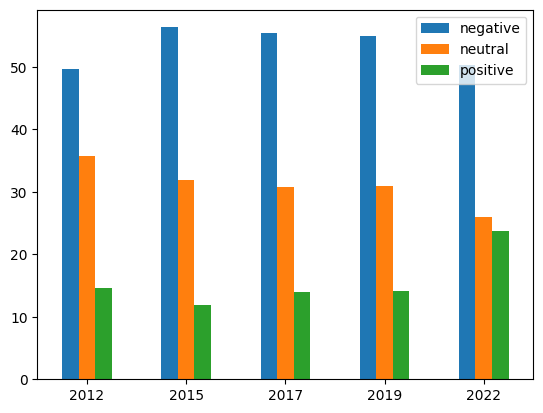

In [13]:
# Run this cell to create a bar chart and visualise the table generated above

Negative = [49.674419, 56.338652, 55.396096, 54.907539, 50.276243]
Neutral = [35.674419, 31.826241, 30.711825, 31.009957, 25.966851]
Positive = [14.651163, 11.835106, 13.892078, 14.082504, 23.756906]
index = ['2012', '2015', '2017','2019', '2022']
df_vis = pd.DataFrame({'negative': Negative,'neutral': Neutral,'positive': Positive}, index=index)
ax = df_vis.plot.bar(rot=0)

### **Emotion Analysis**




> Emotion detection is a means of identifying distinct human emotion types such as furious, cheerful, or depressed. “Emotion detection,” “affective computing,” “emotion analysis,” and “emotion identification” are all phrases that are sometimes used interchangeably

```Nandwani, P., Verma, R. A review on sentiment analysis and emotion detection from text. Soc. Netw. Anal. Min. 11, 81 (2021). https://doi.org/10.1007/s13278-021-00776-6```

<br>

**The two-dimensional structure of emotions from (Watson and Tellegen, 1985)**

<br /><center><img src='https://drive.google.com/uc?id=1nkaOMhySmwfsy-kvBTXsLRU9Q0yUri8r'></center>


In [14]:
df['Titles'] = df['Titles'].astype(str)
str_titles = ','.join(df['Titles'])
text_object = NRCLex(str_titles)
text_object.affect_frequencies['fear']
text_object.affect_frequencies['anger']
text_object.affect_frequencies['anticip']
text_object.affect_frequencies['trust']
text_object.affect_frequencies['surprise']
text_object.affect_frequencies['sadness']
text_object.affect_frequencies['disgust']
text_object.affect_frequencies['joy']

data = text_object.raw_emotion_scores
data

{'fear': 3789,
 'negative': 4750,
 'sadness': 2423,
 'surprise': 1369,
 'trust': 2043,
 'anger': 2872,
 'positive': 2556,
 'anticipation': 1665,
 'joy': 987,
 'disgust': 920}

In [15]:
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h',
             width = 800, height = 400)
fig.show()

### **Experimenting with Emotion Analysis**

**List of 28 emotions supported by the [model](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment):**

|        |                |             |             |
|---------------|----------------|-------------|-------------|
| admiration    | amusement      | anger       | annoyance   |
| approval      | caring         | confusion   | curiosity   |
| desire        | disappointment | disapproval | disgust     |
| embarrassment | excitement     | fear        | gratitude   |
| grief         | joy            | love        | nervousness |
| optimism      | pride          | realization | relief      |
| remorse       | sadness        | surprise    | neutral     |

In [4]:
#@title **Hands-on: try some sentences to predict emotions**
text = "I hope it works!" #@param {type:"string"}
from transformers import T5ForConditionalGeneration, T5Tokenizer
model = T5ForConditionalGeneration.from_pretrained("kiri-ai/t5-base-qa-summary-emotion")
tokenizer = T5Tokenizer.from_pretrained("kiri-ai/t5-base-qa-summary-emotion")

def emotion(context):
    input_text = f"emotion: {context}"
    features = tokenizer([input_text], return_tensors='pt')
    tokens = model.generate(input_ids=features['input_ids'],
            attention_mask=features['attention_mask'], max_length=64)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

emotion("emotion:" + text + "</s>")

'optimism'

In [18]:
#@title Example 1
text = "I love the German bakeries in Sydney. Together with my imported honey it feels like home" #@param {type:"string"}

def emotion(context):
    input_text = f"emotion: {context}"
    features = tokenizer([input_text], return_tensors='pt')
    tokens = model.generate(input_ids=features['input_ids'],
            attention_mask=features['attention_mask'], max_length=64)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

emotion("emotion:" + text + "</s>")

'love'

In [28]:
#@title Example 2
text = "OMG! Beyonce's new album was just released!" #@param {type:"string"}

def emotion(context):
    input_text = f"emotion: {context}"
    features = tokenizer([input_text], return_tensors='pt')
    tokens = model.generate(input_ids=features['input_ids'],
            attention_mask=features['attention_mask'], max_length=64)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

emotion("emotion:" + text + "</s>")

'excitement'

In [30]:
#@title Example 3
text = "The new manager is terrible " #@param {type:"string"}

def emotion(context):
    input_text = f"emotion: {context}"
    features = tokenizer([input_text], return_tensors='pt')
    tokens = model.generate(input_ids=features['input_ids'],
            attention_mask=features['attention_mask'], max_length=64)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

emotion("emotion:" + text + "</s>")

'fear'